## Import packages

In [1]:
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import scipy.stats as sc
import metpy as mtp
import math
from scipy import integrate
import pandas as pd

from matplotlib.pyplot import cm
import datetime as dt

import cartopy.crs as ccrs
from numpy.random import default_rng

import sys  
sys.path.insert(0, '../')
import ERA5_functions as era_fncts

%load_ext autoreload
%autoreload 2

### Constants

In [2]:
a=6371220 #radius of earth in m
L=2.5E6 #Latent heat in atmosphere
L_ice=3.34e5 #Latent heat of fusion
g=9.81 #Acceleration from gravity
conv_pw=1e15 #Conversion from watts to PW
cp=1007          
    

### Dims

In [3]:
lats = np.linspace(90, -90, 361)
lons = np.linspace(0, 359.5, 720)
levels = [1, 2, 3, 5, 7, 10, 20, 30, 50, 70, 100, 125, 150, 175, 200, 225, 250, 300, 350,
            400, 450, 500, 550, 600, 650, 700, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]
geometry = 2 * np.pi * np.cos(np.deg2rad(np.asarray(lats))) * a / g

### Load instantaneous AHT calcs

In [4]:
aht_ds = xr.open_dataset('../aht_time_series/era5_aht_time_series.nc')

### Make a possible paper figure on AHT distributions and seasons

In [5]:
seasons = ['DJF', 'JJA', 'MAM', 'SON']

season_colors = ['blue', 'red', 'green', 'orange']

season_color_dict = dict(zip(seasons, season_colors))

<ipython-input-6-af277a74097b>:58: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7ff2cc7af640> has a label of '_line0' which cannot be automatically added to the legend.
  leg1=plt.legend([lines1[i] for i in include1],[lines1[i].get_label() for i in include1],
<ipython-input-6-af277a74097b>:58: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7ff2cc7af400> has a label of '_line1' which cannot be automatically added to the legend.
  leg1=plt.legend([lines1[i] for i in include1],[lines1[i].get_label() for i in include1],
<ipython-input-6-af277a74097b>:58: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7ff2cc5faac0> has a label of '_line2' which cannot be automatically added to the legend.
  leg1=plt.legend([lines1[i] for i in include1],[lines1[i].get_label() for i in include1],
<ipython-input-6-af277a74097b>:58: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7ff2cc4d1af0> has a label of '_line3' which cannot be automatically added to

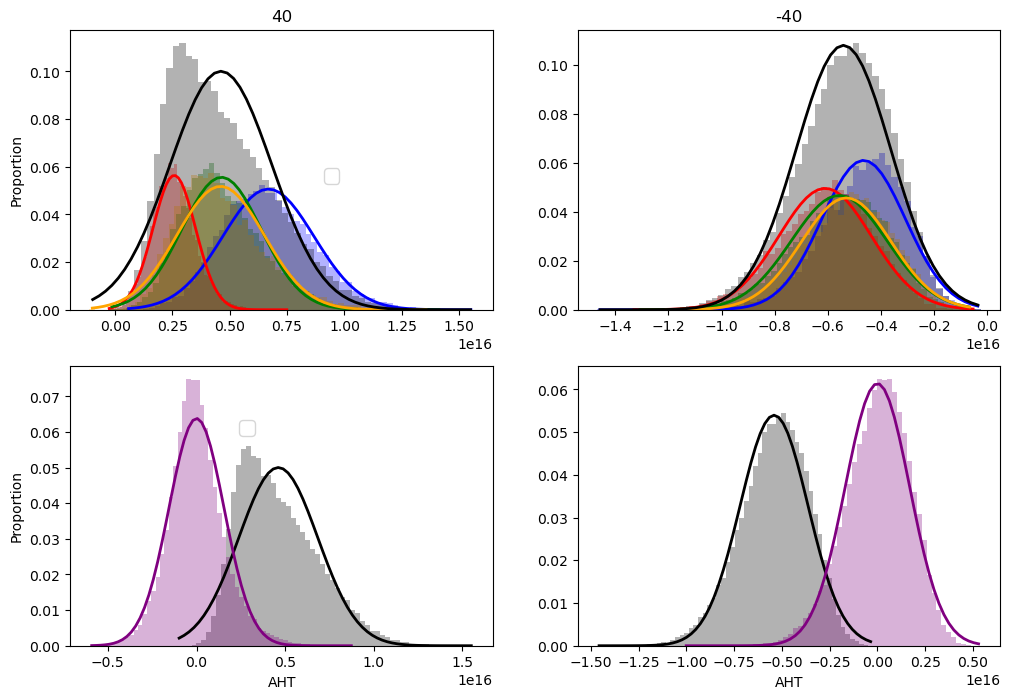

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

which_lat1 = 40
which_lat2 = -40


eddy_aht_grouped = aht_ds.eddy_aht.groupby('time.season')
for sea in seasons:
    eddy_aht = eddy_aht_grouped[sea]
    eddy_aht1 = eddy_aht.sel(latitude=which_lat1)
    eddy_aht2 = eddy_aht.sel(latitude=which_lat2)
    
    era_fncts.plot_hist_and_gauss(axs[0,0], eddy_aht1, season_color_dict[sea], label=sea)
    
    era_fncts.plot_hist_and_gauss(axs[0,1], eddy_aht2, season_color_dict[sea])


full_year_data1 = aht_ds.eddy_aht.sel(latitude=which_lat1)
era_fncts.plot_hist_and_gauss(axs[0,0], full_year_data1, 'k', scale_up=2, label='Full year')


full_year_data2 = aht_ds.eddy_aht.sel(latitude=which_lat2)
era_fncts.plot_hist_and_gauss(axs[0,1], full_year_data2, 'k', scale_up=2)


era_fncts.plot_hist_and_gauss(axs[1,0], aht_ds.eddy_aht.sel(latitude=which_lat1), 'k')
era_fncts.plot_hist_and_gauss(axs[1,0], aht_ds.eddy_aht_no_seasons.sel(latitude=which_lat1), 'purple')

era_fncts.plot_hist_and_gauss(axs[1,1], aht_ds.eddy_aht.sel(latitude=which_lat2), 'k',
                   label='AHT w/ seasons')
era_fncts.plot_hist_and_gauss(axs[1,1], aht_ds.eddy_aht_no_seasons.sel(latitude=which_lat2), 'purple',
                   label='AHT w/o seasons')


axs[0,0].set_ylabel('Proportion')
axs[1,0].set_ylabel('Proportion')

axs[1,0].set_xlabel('AHT')
axs[1,1].set_xlabel('AHT')

axs[0,0].set_title(str(which_lat1))
axs[0,1].set_title(str(which_lat2))


#plt.plot(lat+200, value[0]/conv_pw, color='k', label='Total AHT')
#plt.plot(lat+200, value[0]/conv_pw, ':', color='k', label='TE')
#plt.plot(lat+200, value[0]/conv_pw, '--', color='k', label='SE')
#plt.plot(lat+200, value[0]/conv_pw, '.', color='k', label='MMC')
 
lines1 = axs[0,0].get_lines()
lines2 = axs[1,1].get_lines()
include1=[0, 1, 2, 3, 4]
include2=[0, 1]
#include = [-1]
loc1=[-.6, 1.65]
loc2=[-.8, 0.75]

leg1=plt.legend([lines1[i] for i in include1],[lines1[i].get_label() for i in include1],
                loc=loc1, fontsize=14)
leg2=plt.legend([lines2[i] for i in include2],[lines2[i].get_label() for i in include2],
                loc=loc2, fontsize=14)

plt.gca().add_artist(leg1)

#plt.savefig('figures/2_8_22_meeting/eddy_aht_dist_with_seasons_paper_fig')

plt.show()


### Alternative plot idea

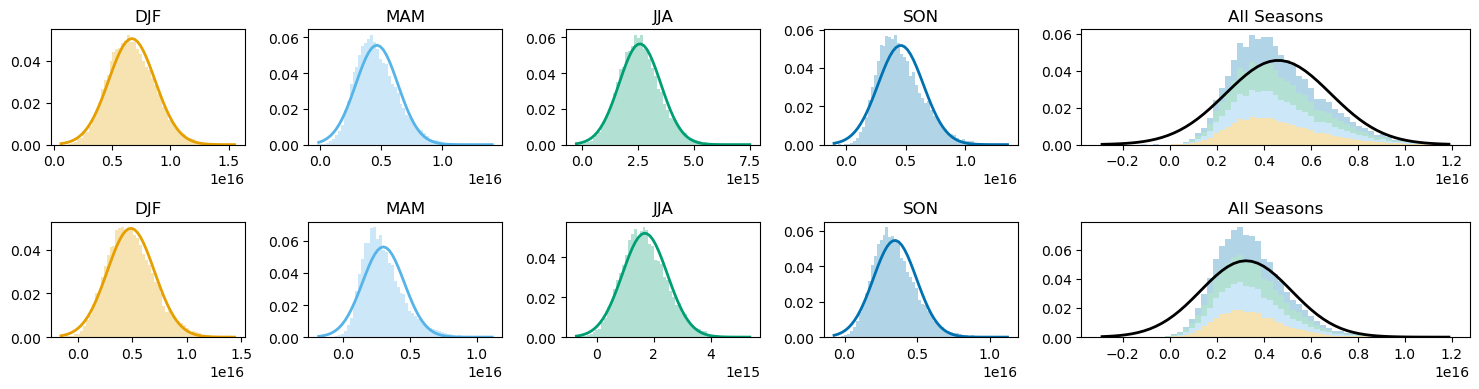

In [7]:
fig, axs = plt.subplots(2, 5, figsize=(15,4), gridspec_kw={'width_ratios': [1, 1, 1, 1, 2]})

which_lat1 = 40
which_lat2 = 60

eddy_aht_grouped = aht_ds.eddy_aht.groupby('time.season')

seasons = ['DJF', 'MAM', 'JJA', 'SON']
season_colors = ['#E69F00', '#56B4E9', '#009E73', '#0072B2']

season_color_dict = dict(zip(seasons, season_colors))

axs_for_plots1 = np.delete(axs.reshape(-1), 4)[:4]
axs_for_plots2 = np.delete(axs.reshape(-1), 4)[4:8]

for idx, ax in enumerate(axs_for_plots1):
    eddy_aht = eddy_aht_grouped[seasons[idx]].sel(latitude=which_lat1).values.flatten()
    era_fncts.plot_hist_and_gauss(ax, eddy_aht, season_colors[idx])
    ax.set_title(seasons[idx])
    
for idx, ax in enumerate(axs_for_plots2):
    eddy_aht = eddy_aht_grouped[seasons[idx]].sel(latitude=which_lat2).values.flatten()
    era_fncts.plot_hist_and_gauss(ax, eddy_aht, season_colors[idx])
    ax.set_title(seasons[idx])
    
num_bins = 60

which_bins = np.linspace(-.3e16, 1.2e16, num_bins)
# Get the mid points of every bin
bin_middles = (which_bins[1:]+which_bins[:-1])/2.
# Compute the bin-width
bin_width = which_bins[1]-which_bins[0]


probs = np.zeros(((len(seasons)), num_bins - 1))
for i in range(len(seasons)):
    eddy_data = eddy_aht_grouped[seasons[idx]].sel(latitude=which_lat1).values.flatten()
    n_bins, bin_edges = np.histogram(eddy_data.flatten(), which_bins)
    bin_probability = (n_bins/float(n_bins.sum())) / len(seasons)
    probs[i,:] = bin_probability
    axs[0,4].bar(bin_middles, bin_probability, bottom=np.sum(probs[:i,:], axis=0),
            width=bin_width, color = season_colors[i], alpha=0.3)
    
probs = np.zeros(((len(seasons)), num_bins - 1))
for i in range(len(seasons)):
    eddy_data = eddy_aht_grouped[seasons[idx]].sel(latitude=which_lat2).values.flatten()
    n_bins, bin_edges = np.histogram(eddy_data.flatten(), which_bins)
    bin_probability = (n_bins/float(n_bins.sum())) / len(seasons)
    probs[i,:] = bin_probability
    axs[1,4].bar(bin_middles, bin_probability, bottom=np.sum(probs[:i,:], axis=0),
            width=bin_width, color = season_colors[i], alpha=0.3)

#Add Gaussians to the right columns
(mu, sigma) = sc.norm.fit(aht_ds.eddy_aht.sel(latitude=which_lat1).values)
# The pdf should not normed anymore but scaled the same way as the data
gaus = sc.norm.pdf(bin_middles, mu, sigma) * bin_width
axs[0,4].plot(bin_middles, gaus, color='k', linewidth=2)

(mu, sigma) = sc.norm.fit(aht_ds.eddy_aht.sel(latitude=which_lat2).values)
# The pdf should not normed anymore but scaled the same way as the data
gaus = sc.norm.pdf(bin_middles, mu, sigma) * bin_width
axs[1,4].plot(bin_middles, gaus, color='k', linewidth=2)

axs[0,4].set_title('All Seasons')
axs[1,4].set_title('All Seasons')

plt.tight_layout()
#plt.savefig('figures/3_15_22_meeting/eddy_aht_pdfs_seasons_alt')

plt.show()

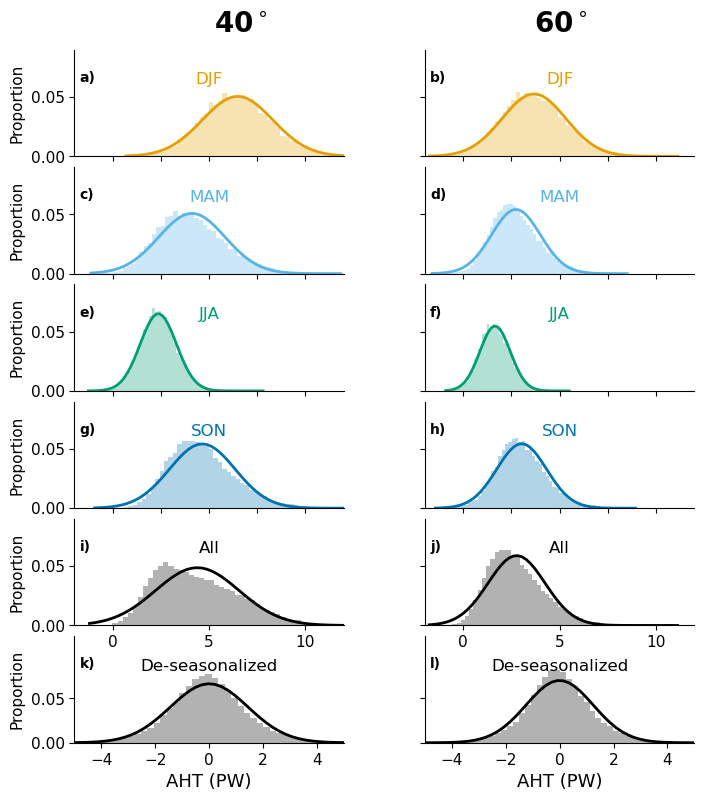

In [15]:
fig, axs = plt.subplots(6, 2, figsize=(8, 9))

lat1 = 40
lat2 = 60

which_field = aht_ds.total_aht / 1e15

seasons = ['DJF', 'MAM', 'JJA', 'SON']

season_colors = ['#E69F00', '#56B4E9', '#009E73', '#0072B2']
season_color_dict = dict(zip(seasons, season_colors))

ax_y_lim = [0, 0.09]

axs_for_plots1 = [axs[0, 0], axs[1, 0], axs[2, 0], axs[3, 0]]
axs_for_plots2 = [axs[0, 1], axs[1, 1], axs[2, 1], axs[3, 1]]

skew_values = np.zeros(len(axs.flatten()))

for idx, ax in enumerate(axs_for_plots1):
    season_aht = which_field.sel(latitude=lat1).groupby('time.season')[seasons[idx]]
    era_fncts.plot_hist_and_gauss(ax, season_aht, season_colors[idx], label=seasons[idx])
    
    skew_values[idx] = sc.skew(season_aht)
    #ax.text(x=1.0e16, y=0.02, s='Skew: ' + str(round(sc.skew(season_aht), 2)))
    #ax.text(x=1.0e16, y=0.01, s='Kurtosis: ' + str(round(sc.kurtosis(season_aht), 2)))

era_fncts.plot_hist_and_gauss(axs[4,0], which_field.sel(latitude=lat1).values.flatten(), 'k', label='All seasons')
era_fncts.plot_hist_and_gauss(axs[5,0], aht_ds.total_aht_no_seasons.sel(latitude=lat1).values.flatten()/1e15,
                              'k', label='All seasons') 
skew_values[4] = sc.skew(which_field.sel(latitude=lat1).values.flatten())
#axs[4,0].text(x=1.0e16, y=0.02, s='Skew: ' + str(round(sc.skew(which_field.sel(latitude=lat1).values.flatten()), 2)))
#axs[4,0].text(x=1.0e16, y=0.01, s='Kurtosis: ' + str(round(sc.kurtosis(which_field.sel(latitude=lat1).values.flatten()), 2)))

for idx, ax in enumerate(axs_for_plots2):
    season_aht = which_field.sel(latitude=lat2).groupby('time.season')[seasons[idx]]
    era_fncts.plot_hist_and_gauss(ax, season_aht, season_colors[idx], label=seasons[idx])
    skew_values[4+idx] = sc.skew(season_aht)
    #ax.text(x=1.0e16, y=0.02, s='Skew: ' + str(round(sc.skew(season_aht), 2)))
    #ax.text(x=1.0e16, y=0.01, s='Kurtosis: ' + str(round(sc.kurtosis(season_aht), 2)))

era_fncts.plot_hist_and_gauss(axs[4,1], which_field.sel(latitude=lat2).values.flatten(), 'k', label='All seasons')
era_fncts.plot_hist_and_gauss(axs[5,1], aht_ds.total_aht_no_seasons.sel(latitude=lat2).values.flatten()/1e15,
                              'k', label='All seasons') 
skew_values[9] = sc.skew(which_field.sel(latitude=lat2).values.flatten())
#fig.legend(loc='upper right')
#axs[4,1].text(x=1.0e16, y=0.02, s='Skew: ' + str(round(sc.skew(which_field.sel(latitude=lat2).values.flatten()), 2)))
#axs[4,1].text(x=1.0e16, y=0.01, s='Kurtosis: ' + str(round(sc.kurtosis(which_field.sel(latitude=lat2).values.flatten()), 2)))

plt.subplots_adjust(wspace=0.3, hspace=.1)

subplot_labels = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)', 'i)', 'j)', 'k)', 'l)', 'm)']
for i, ax_dub in enumerate((axs)):
    for j, ax in enumerate(ax_dub):
        ax.patch.set_visible(False)
        ax.set_ylim(ax_y_lim)
        ax.set_yticks([0, .05])
        for sp in ["top", "right"]:
            ax.spines[sp].set_visible(False)
        ax.set_title(np.append(seasons,['All', 'De-seasonalized'])[i], x=0.5, y=.6,
                     color=np.append(season_colors, ['k','k'])[i])
        
        if i <= 4:
            ax.set_xlim([-2, 12])
            
        else:
            ax.set_xlim([-5, 5])
            ax.set_ylim([0, .12])
            ax.tick_params(axis='both', which='major', labelsize=11)
            ax.set_xlabel('AHT (PW)', fontsize=13)
            
        if i ==4:
            ax.tick_params(axis='both', which='major', labelsize=11)
            
        if i <= 3:
            ax.set_xticklabels([])
            ax.tick_params(axis='y', which='major', labelsize=11)
            
        if j == 0:
            ax.set_ylabel('Proportion', fontsize=11)
            
        if j ==1:
            ax.set_yticklabels([])
            
        ax.text(x=0.02, y=0.7, s=subplot_labels[i*2 + j], transform=ax.transAxes, fontweight='bold')

fig.text(x=0.3, y=0.9, s='40$^\circ$', fontsize=20, fontweight='bold')
fig.text(x=0.7, y=0.9, s='60$^\circ$', fontsize=20, fontweight='bold')
#for i, ax in enumerate(axs.flatten()):
    #ax.text(x=-.2e16, y=0.02, s=str(round(skew_values[i], 2)))
#fig.savefig('../figures/4_12_22_meeting/total_aht_pdfs_seasons_stacked_style')



plt.show()

### Try to take the Guassian approximations for each season and re-create the annual PDF

In [9]:
def hist_gauss(data, which_bins=np.linspace(-.1e16, 1.5e16, 100), scale_up=1, label='', plot_gaus=True):
    '''Takes data and an axis and plots a histogram and Gaussian fit of the data
    
    Args:
        -axs(matplotlib axis): Axis on which to plot things
        -data(array-like): Array of data to plot
        -which_color(str): Color to plot the data in
        -which_bins(int or array, default=60): Number of bins or the bins for the histograms
        -scale_up(int or float, default=1): Increase magnitude of data plotted
        -label(str): Label for the data
    
    Outputs:
        -Plots things
    '''
    
    # Bin it
    #Which bins can either be an int (# of bins) or the bins themselves
    n_bins, bin_edges = np.histogram(data, which_bins) 
    # Normalize it, so that every bins value gives the probability of that bin
    bin_probability = n_bins/float(n_bins.sum())
    # Get the mid points of every bin
    bin_middles = (bin_edges[1:]+bin_edges[:-1])/2.
    # Compute the bin-width
    bin_width = bin_edges[1]-bin_edges[0]
    # Plot the histogram as a bar plot
    #axs.bar(bin_middles, scale_up * bin_probability, width=bin_width,
            #color=which_color, alpha=0.3, label=label)

    # Fit to normal distribution
    (mu, sigma) = sc.norm.fit(data)
    # The pdf should not normed anymore but scaled the same way as the data
    gaus = sc.norm.pdf(bin_middles, mu, sigma) * bin_width
    
    #if plot_gaus == True:
        #axs.plot(bin_middles, gaus * scale_up, color=which_color, linewidth=2)
    #else:
        #pass
    
    return bin_middles, bin_probability, gaus

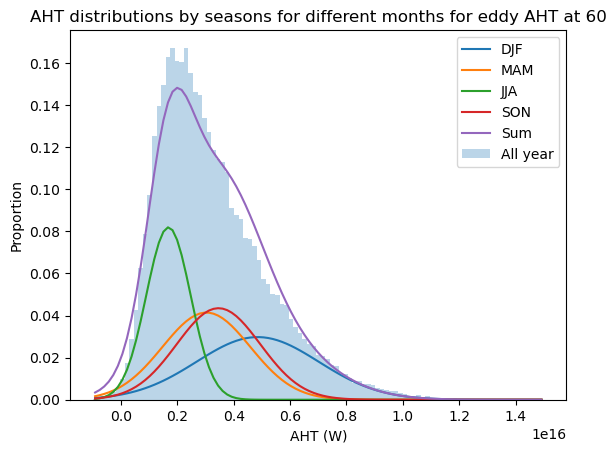

In [10]:
which_lat1 = 60
which_lat2 = -40
eddy_aht_grouped = aht_ds.eddy_aht.groupby('time.season')

bins = np.linspace(-.1e16, 1.5e16, 60)

gaus_sum = np.zeros(99)
for sea in seasons:
    
    eddy_aht = eddy_aht_grouped[sea].sel(latitude=which_lat1)
    # Fit to normal distribution
    
    bin_middles, bin_probs, gaus = hist_gauss(eddy_aht)
    
    plt.plot(bin_middles, gaus, label=sea)
    #(mu, sigma) = sc.norm.fit(eddy_aht)
    # The pdf should not normed anymore but scaled the same way as the data
    #gaus = sc.norm.pdf(bins, mu, sigma)
    
    #plt.plot(bins, gaus, label=sea)
    gaus_sum += gaus
    
plt.plot(bin_middles, gaus_sum, label='Sum')

bin_middles, bin_probs, gaus = hist_gauss(aht_ds.eddy_aht.sel(latitude=which_lat1))
bin_width = bin_middles[1]-bin_middles[0]
plt.bar(bin_middles, bin_probs * 4, width=bin_width, alpha=0.3, label='All year')
    
plt.legend(loc=0)

plt.ylabel('Proportion')
plt.xlabel('AHT (W)')

plt.title('AHT distributions by seasons for different months for eddy AHT at ' + str(which_lat1))

#plt.savefig('figures/2_22_22_meeting/eddy_gaus_distributions_seasons_total_' + str(which_lat1))

plt.show()

### Plot a distribution of AHT at one latitude locally and color by month

DJF mean is : 1.9944994100311861 and std is: 7.448976819210694
JJA mean is : 1.1014986775091888 and std is: 3.4089663617949038
MAM mean is : 1.3754714186800978 and std is: 5.138210449941988
SON mean is : 1.5276293784525306 and std is: 5.303859948936659


<Figure size 800x600 with 0 Axes>

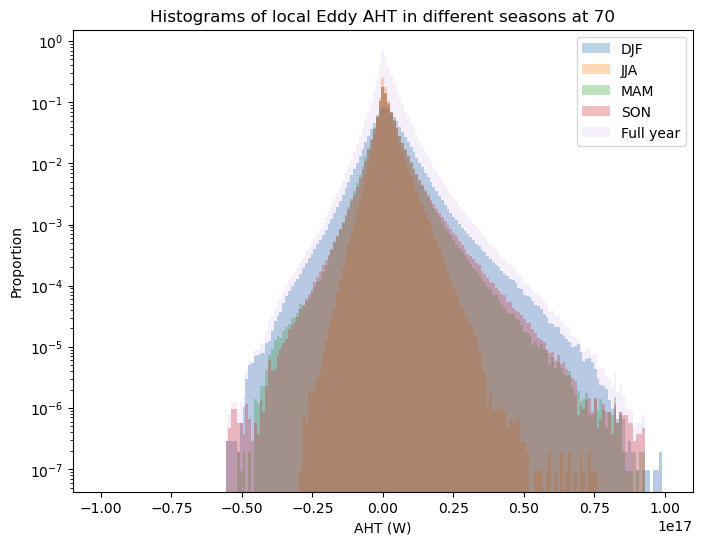

In [12]:
plt.figure(figsize=(8,6))

which_lat = 70

aht_ds_local = xr.open_dataset('../aht_time_series/era5_aht_time_series_' + str(which_lat) + 'deg.nc')

eddy_aht_grouped = aht_ds_local.eddy_aht.groupby('time.season')

bin_edges = np.linspace(-1e17, 1e17, 200)

colors = ['r', 'g', 'b', 'y']

#print(eddy_aht_grouped)
for idx, sea in enumerate(['DJF', 'JJA', 'MAM', 'SON']):
    eddy_aht = eddy_aht_grouped[sea].values.flatten()
    print(sea + ' mean is : ' + str(np.mean(eddy_aht/1e15))+ ' and std is: ' + str(np.std(eddy_aht/1e15)))

    #era_fncts.plot_hist_and_gauss(plt, eddy_aht, colors[idx],
                              #which_bins=bin_edges, label=sea)
    plt.hist(eddy_aht, weights=np.ones(len(eddy_aht)) / len(eddy_aht), bins=bin_edges, alpha=0.3, label=sea)
   
full_year_data = aht_ds_local.eddy_aht.values.flatten()
#era_fncts.plot_hist_and_gauss(plt, full_year_data, 'k',
                              #which_bins=bin_edges, label='Full Year')
    
plt.hist(full_year_data, weights=4*np.ones(len(full_year_data)) / len(full_year_data), bins=bin_edges, alpha=0.1, label='Full year')
plt.legend(loc=0)
plt.xlabel('AHT (W)')

plt.ylabel('Proportion')

plt.title('Histograms of local Eddy AHT in different seasons at ' + str(which_lat))

#plt.savefig('figures/2_8_22_meeting/mmc_aht_distributions_seasons_' + str(which_lat) +'deg')
plt.yscale('log')
plt.show()